In [1]:
!unzip -qq /content/drive/MyDrive/RockClassificationDataset.zip

In [2]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:11tcmalloc: large alloc 1147494400 bytes == 0x55dcb2c20000 @  0x7f679a81a615 0x55dc79b53cdc 0x55dc79c3352a 0x55dc79b56afd 0x55dc79c47fed 0x55dc79bca988 0x55dc79bc54ae 0x55dc79b583ea 0x55dc79bca7f0 0x55dc79bc54ae 0x55dc79b583ea 0x55dc79bc732a 0x55dc79c48e36 0x55dc79bc6853 0x55dc79c48e36 0x55dc79bc6853 0x55dc79c48e36 0x55dc79bc6853 0x55dc79c48e36 0x55dc79ccb3e1 0x55dc79c2b6a9 0x55dc79b96cc4 0x55dc79b57559 0x55dc79bcb4f8 0x55dc79b5830a 0x55dc79bc63b5 0x55dc79bc57ad 0x55dc79b583ea 0x55dc79bc63b5 0x55dc79b5830a 0x55dc79bc63b5
     |█████████████████████████████▏  | 1055.7MB 1.3MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x55dcf7276000 @  0x7f679a81a615 0x55dc79b53cdc 0x55dc79c3352a 0x55dc79b56afd 0x55dc79c47fed 0x55dc79bca988 0x55dc79bc54ae 0x55dc79b583ea 0x55dc79bca7f0 0x55dc79bc54ae 0x55dc79b583ea 0x55dc79bc732a 0x55dc79c48e36 0x55dc79bc6853 0

In [3]:
import numpy as np 
import pandas as pd 
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import  DataLoader, WeightedRandomSampler, SubsetRandomSampler, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("Pytorch Version: ",torch.__version__)
print("Torchvision Version ",torchvision.__version__)

Pytorch Version:  1.7.1+cu110
Torchvision Version  0.8.2+cu110


In [4]:
train_transform = transforms.Compose(
                                         [transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
                                    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


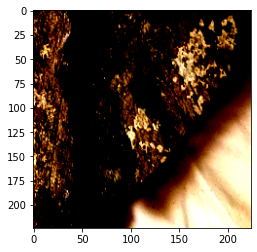

0 Basalt


In [5]:
# Loading the datasets and plot some images
dataset = datasets.ImageFolder('/content/RockClassificationDataset',transform=train_transform)
img,label = dataset[15]
plt.imshow(img.permute(2,1,0))
plt.show()
print(label, dataset.classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']
dataset size:  2076


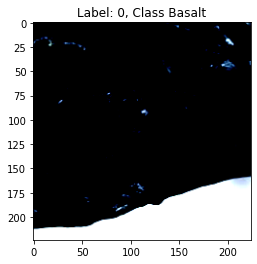

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


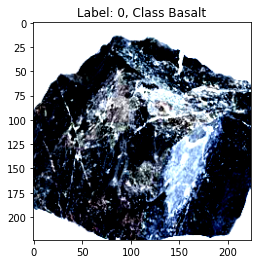

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


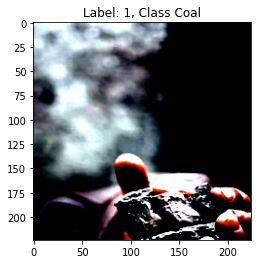

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


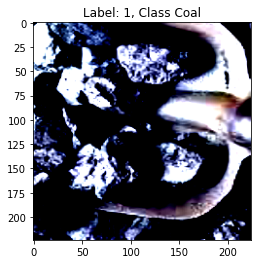

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


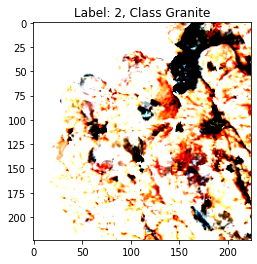

In [6]:
print(dataset.classes)
print('dataset size: ', len(dataset))
class_names = dataset.classes

for i in 0, 10, 100, 200, 500:
    img,label = dataset[i]
    plt.title(f'Label: {label}, Class {class_names[label]}')
    plt.imshow(img.permute(2,1,0))
    plt.show()

In [7]:
labels = dataset.targets

In [8]:
_,labels_count = np.unique(labels, return_counts=True)
labels_count

array([ 86, 369, 101, 333, 385, 477, 325])

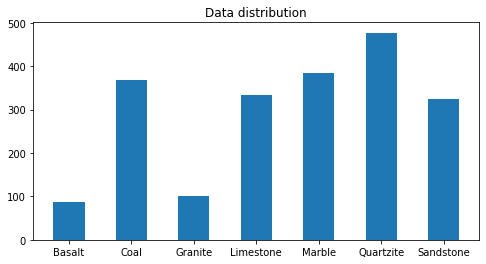

array([ 4.1, 17.8,  4.9, 16. , 18.5, 23. , 15.7])

In [9]:
plt.figure(figsize=(8, 4))
plt.title('Data distribution')
plt.bar(class_names, labels_count, width=.5)
plt.show()

# view percentage of each class
distribution_perc = 100*labels_count/len(dataset)
distribution_perc.round(1)

In [10]:
#size of dataset
dataset_size = len(dataset)
distribution_perc = 100*labels_count/dataset_size

for class_name, count, distrib in zip(class_names,labels_count,distribution_perc):
    print(f'{class_name} {distrib:.2f}% - {count} Images')
print('Total Images:',dataset_size,'Images')

Basalt 4.14% - 86 Images
Coal 17.77% - 369 Images
Granite 4.87% - 101 Images
Limestone 16.04% - 333 Images
Marble 18.55% - 385 Images
Quartzite 22.98% - 477 Images
Sandstone 15.66% - 325 Images
Total Images: 2076 Images


In [11]:
#spllit each class into 20% for test and 80% for train bcz all have #nt size
from sklearn.model_selection import train_test_split

#split train and test
train_idx, valid_idx = train_test_split(
    np.arange(dataset_size),
    test_size = 0.1,
    shuffle = True,
    stratify = labels  # take uniform distribution of each class
)

In [12]:
# test if all dataset are split well
labelss = np.array(labels)
_,valid_dist = np.unique(labelss[valid_idx], return_counts=True)
valid_dist

array([ 9, 37, 10, 33, 39, 48, 32])

In [13]:
labels_count

array([ 86, 369, 101, 333, 385, 477, 325])

In [14]:
train_set, val_set = torch.utils.data.random_split(dataset, [1800, 276])

In [15]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()} 
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1        
    return count_dict

idx2class = {v: k for k, v in dataset.class_to_idx.items()}

target_list = torch.tensor(dataset.targets)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in get_class_distribution(dataset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[target_list]

In [16]:
# SubsetRandomSampler(Help to split our data randomly or shuffled) 
batch_size = 64

train_sampler = WeightedRandomSampler(class_weights, num_samples=1800)
valid_sampler = WeightedRandomSampler(class_weights, num_samples=276)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler) #shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, sampler=valid_sampler)

In [22]:
model = models.resnext101_32x8d(pretrained=True)

# view last input channels
in_features = model.fc.in_features

#lock previous layer
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device)

# loss function
criteration = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

# param.requires_grad = False
for epoch in range(10):
    print(f'\n-----epoch {epoch+1}-----')
    number_corect = 0
    sum_loss = 0
    val_cor = 0
    for datas, targets in train_loader:
        datas = datas.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        #predict
        outputs = model(datas)
        #update model
        loss = criteration(outputs, targets)
        #update model
        loss.backward()
        optimizer.step()
        #compute metrics
        max_index = outputs.max(dim=1)[1]
        sum_loss +=loss.item()
        number_corect += (max_index == targets.data).sum()
    
    '''     for datas, targets in valid_loader:
        datas = datas.to(device)
        targets = targets.to(device)
        #predict
        outputs = model(datas)
        #compute metrics
        max_index = outputs.max(dim=1)[1]
        val_cor += (max_index == targets.data).sum()'''

    #print metrics
    loss = sum_loss / len(train_loader)
    accuracy = 100.0*number_corect / 1800
    #accuracy_val = 100.0*val_cor / 276
    print(f'Loss {loss}, \nAccuracy {accuracy}')#, \nVal Accuracy {accuracy_val}')

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth




-----epoch 1-----
Loss 1.430359486875863, 
Accuracy 51.16666793823242

-----epoch 2-----
Loss 0.9483186129865975, 
Accuracy 75.83333587646484

-----epoch 3-----
Loss 0.6986667452187374, 
Accuracy 85.61111450195312

-----epoch 4-----
Loss 0.5851507680169468, 
Accuracy 89.3888931274414

-----epoch 5-----
Loss 0.4856365405280015, 
Accuracy 95.55555725097656

-----epoch 6-----
Loss 0.40263672327173167, 
Accuracy 98.0

-----epoch 7-----
Loss 0.36529993805392036, 
Accuracy 98.94445037841797

-----epoch 8-----
Loss 0.29850800181257314, 
Accuracy 98.94445037841797

-----epoch 9-----
Loss 0.26351071894168854, 
Accuracy 99.16667175292969

-----epoch 10-----
Loss 0.2443360501322253, 
Accuracy 99.61111450195312


# Testing

In [23]:
# reference https://discuss.pytorch.org/t/how-to-find-test-accuracy-after-training/88962
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() 
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    model.train()

In [24]:
check_accuracy(train_loader, model)

Got 1798 / 1800 with accuracy 99.89
